## Import libs and data

In [1]:
import dask.dataframe as dd
import os
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
final_dataset_path = '..\data\FEData_For_Modelling.parquet'

# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


OWH: Outside Work Hours  
WH: Work Hours  
WKE: Weekend  
  
FC: files copied  
SD: Sus Domain  
CD: Cloud Domain  
JD: Job Domain  


## Add target labels

In [3]:
def list_files_in_folder(folder_path):
    files = []
    # Check if the folder path exists
    if os.path.exists(folder_path):
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            # Check if the path is a file (not a directory)
            if os.path.isfile(os.path.join(folder_path, file_name)):
                files.append(file_name[7:-4])
    else:
        print(f"Folder '{folder_path}' does not exist.")
    return files

sus_users_list = list_files_in_folder("..\data\\r5.2-2")
fds["targetLabel"] = fds['user'].apply(lambda x: 1 if x in sus_users_list else 0, meta=('int'))

In [4]:
print("How many sus users: ",len(sus_users_list))
print(sus_users_list)

How many sus users:  30
['BYO1846', 'CHP1711', 'CIF1430', 'CKP0630', 'DCC1119', 'GWG0497', 'HIS1394', 'HMS1658', 'HSN0675', 'HXP0976', 'ICB1354', 'ITA0159', 'JAL0811', 'KSS1005', 'LVF1626', 'MCP0611', 'MDS0680', 'MGB1235', 'NAH1366', 'OKM1092', 'OSS1463', 'RRS0056', 'SIS0042', 'SNK1280', 'TMT0851', 'TNB1616', 'TRC1838', 'VCF1602', 'WDT1634', 'ZIE0741']


In [5]:
(fds["targetLabel"] == 1).sum().compute()

30

In [6]:
y = fds["targetLabel"].compute()
X = fds.drop(columns=["targetLabel",]).compute()
# X = fds.drop(columns=["targetLabel","user"]).compute()

## Preprocessing and Split

In [7]:
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])
print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


In [8]:
from sklearn.preprocessing import StandardScaler
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model training (basic)

In [9]:
# Create a One-Class SVM model
clf = OneClassSVM(nu=0.1) 
# Fit the model on the training data
clf.fit(X_train_scaled, y_train) 

OneClassSVM(nu=0.1)

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1574
           1       0.01      0.04      0.01        26

    accuracy                           0.88      1600
   macro avg       0.49      0.47      0.47      1600
weighted avg       0.97      0.88      0.92      1600



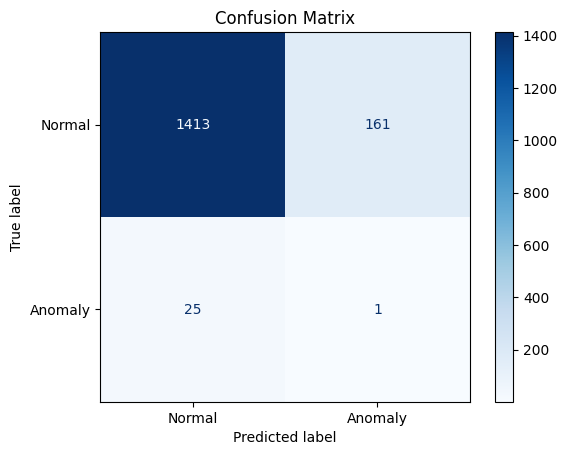


##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       396
           1       0.02      0.25      0.04         4

    accuracy                           0.87       400
   macro avg       0.51      0.56      0.48       400
weighted avg       0.98      0.87      0.92       400



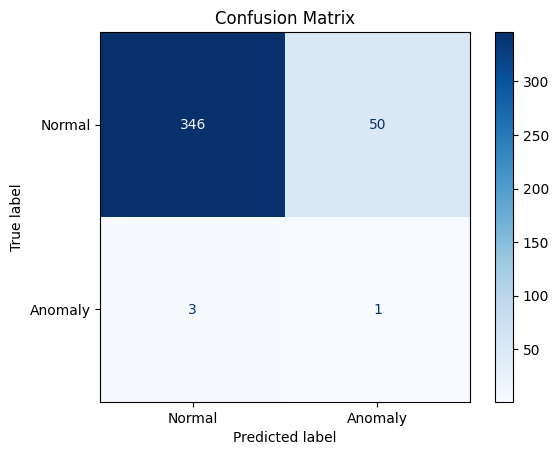

In [10]:

def eval_svm(preds, labels):

    # Convert predictions (-1 for outliers, 1 for inliers) to binary labels (0 for normal, 1 for anomaly)
    pred_labels = np.where(preds == -1, 1, 0)
    print(classification_report(labels, pred_labels))

    conf_matrix = confusion_matrix(labels, pred_labels)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                   display_labels=["Normal", "Anomaly"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

train_pred = clf.predict(X_train_scaled)
print("##############################")
print("Train Evaluation")
print("##############################")
eval_svm(train_pred, y_train)

print()

test_pred = clf.predict(X_test_scaled)
print("##############################")
print("Test Evaluation")
print("##############################")
eval_svm(test_pred, y_test)

## GridSearch BEST DONT CHANGE

In [11]:
def make_binary_labels(labels):
    return np.where(labels == 1, -1, 1)

y_train_gs = make_binary_labels(y_train)
y_test_gs = make_binary_labels(y_test)


In [12]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred):
    # Compute confusion matrix
    fp = sum((y_true == 1) & (y_pred == -1))  # False Positives
    return precision_score(y_true,y_pred) - fp

# Create a scorer using make_scorer
scorer = make_scorer(custom_scorer, greater_is_better=True)

# defining parameter range 
param_grid = {
    'nu': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 1.0, 10.0]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

grid = GridSearchCV(OneClassSVM(), param_grid, refit = True, verbose = 3, scoring=scorer) 

# fitting the model for grid search 
grid.fit(X_train_scaled, y_train_gs) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END gamma=scale, kernel=linear, nu=0.001;, score=-169.000 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.001;, score=-94.013 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.001;, score=-126.031 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.001;, score=-83.009 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.001;, score=-77.025 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.005;, score=-254.000 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.005;, score=-45.007 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.005;, score=-120.020 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.005;, score=-123.015 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.005;, score=-95.031 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.01;, score=-150.000 total time=   0

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah 

[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-108.010 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=poly, nu=0.7;, score=-111.024 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-210.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-185.008 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-191.016 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-198.008 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=poly, nu=0.9;, score=-3.022 total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=-298.000 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=-109.010 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=-165.033 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=-144.012 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=-212.010 

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-313.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-316.000 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.001;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-315.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-317.000 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-316.000 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.005;, score=-313.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-315.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-317.000 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-313.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-316.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.01;, score=-313.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-315.000 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-317.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-313.000 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-316.000 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=rbf, nu=0.05;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.1;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-315.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-316.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.2;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-317.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.3;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-313.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.5;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-315.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-317.000 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-316.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.7;, score=-313.000 total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-315.000 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-317.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-313.000 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-316.000 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=rbf, nu=0.9;, score=-313.000 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-36.014 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-55.004 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-56.023 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-33.007 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=poly, nu=0.001;, score=-38.011 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-36.014 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-55.004 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-56.023 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-33.007 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=poly, nu=0.005;, score=-38.011 total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=poly, nu=0.01;, score=-35.014 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=poly, nu=0.01;, score=-55.004 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=poly, nu=0.01;, score=-56.023 total time=   0.0s
[CV 4/5] END gamma=

BEST PARAMS?  
OneClassSVM(gamma=10.0, kernel='sigmoid', nu=0.001)  
OneClassSVM(gamma=10.0, kernel='sigmoid', nu=0.001)

  
Notable:  
OneClassSVM(gamma=0.001, kernel='poly', nu=0.05) # many FP, TP

{'gamma': 'scale', 'kernel': 'poly', 'nu': 0.9}

In [13]:
best_clf = grid

##############################
Train Evaluation
##############################
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        26
           1       0.98      0.99      0.99      1574

    accuracy                           0.98      1600
   macro avg       0.49      0.50      0.49      1600
weighted avg       0.97      0.98      0.97      1600



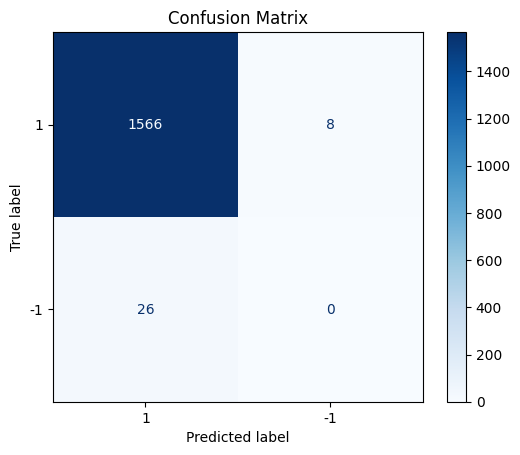

##############################
Test Evaluation
##############################
              precision    recall  f1-score   support

     Inliers       0.99      1.00      1.00       396
    Outliers       1.00      0.25      0.40         4

    accuracy                           0.99       400
   macro avg       1.00      0.62      0.70       400
weighted avg       0.99      0.99      0.99       400



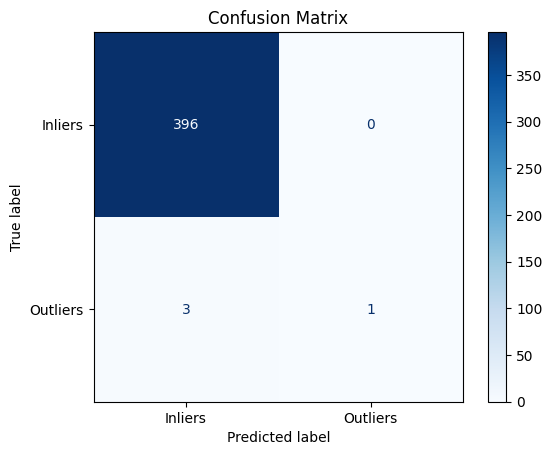

In [14]:
print("##############################")
print("Train Evaluation")
print("##############################")
# wider param grid, no smote
train_pred = best_clf.predict(X_train_scaled) 
print(classification_report(y_train_gs, train_pred)) 


conf_matrix = confusion_matrix(y_train_gs, train_pred, labels=[1, -1])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=[1, -1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# (-1 for outliers, 1 for inliers)
print("##############################")
print("Test Evaluation")
print("##############################")

test_pred = best_clf.predict(X_test_scaled) 
labels = [1, -1]  # -1 for Outliers, 1 for Inliers

print(classification_report(y_true=y_test_gs, y_pred=test_pred,labels=labels, target_names=['Inliers', 'Outliers'])) 

conf_matrix = confusion_matrix(y_test_gs, test_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Inliers', 'Outliers'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## WITH SMOTE

In [15]:
# SMOTE
oversample = SMOTE(sampling_strategy = 0.3, random_state = 42) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 472})


In [16]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled_smote = scaler.fit_transform(resampled_X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
def make_binary_labels(labels):
    return np.where(labels == 1, -1, 1)

y_train_smote = make_binary_labels(resampled_y_train)
y_test_smote = make_binary_labels(y_test)

In [18]:
def custom_scorer(y_true, y_pred):
    # Compute confusion matrix
    fp = sum((y_true == 1) & (y_pred == -1))  # False Positives
    return precision_score(y_true,y_pred) / fp

# Create a scorer using make_scorer
scorer = make_scorer(custom_scorer, greater_is_better=True)

# defining parameter range 
param_grid = {
    'nu': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 1.0, 10.0]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}
# scorer = make_scorer(precision_score, average='weighted')

grid = GridSearchCV(OneClassSVM(), param_grid, refit = True, verbose = 3, scoring=scorer) 


# fitting the model for grid search 
grid.fit(X_train_scaled_smote, y_train_smote) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(X_test_scaled) 

# print classification report 
print(classification_report(y_test_smote, grid_predictions)) 


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s


[CV 5/5] END gamma=scale, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.010 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.002 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.005 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.007 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.008 total time=   0.0s
[CV 5/5] END .gamma=scale, kernel=linear, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.05;, score=0.005 total time=   0.0s
[CV 2/5] END ga

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarni

[CV 1/5] END gamma=scale, kernel=linear, nu=0.3;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.3;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.3;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.3;, score=0.002 total time=   0.0s
[CV 5/5] END ..gamma=scale, kernel=linear, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ..gamma=scale, kernel=linear, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s
[CV 5/5] END ..gamma=scale, kernel=linear, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END gamma=scale, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ..gamma=scale, kernel=linear, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END .gamma=scale, kernel=rbf, nu=0.001;, score=0.022 total time=   0.0s
[CV 2/5] END .gamma=scale, kernel=rbf, nu=0.001;, score=0.019 total time=   0.0s
[CV 3/5] END .gamma=scale, kernel=rbf, nu=0.001;, score=0.018 total time=   0.0s
[CV 4/5] END .gamma=scale, kernel=rbf, nu=0.001;, score=0.023 total time=   0.0s
[CV 5/5] END ...gamma=scale, kernel=rbf, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END .gamma=scale, kernel=rbf, nu=0.005;, score=0.023 total time=   0.0s
[CV 2/5] END .gamma=scale, kernel=rbf, nu=0.005;, score=0.019 total time=   0.0s
[CV 3/5] END .gamma=scale, kernel=rbf, nu=0.005;, score=0.018 total time=   0.0s
[CV 4/5] END .gamma=scale, kernel=rbf, nu=0.005;, score=0.023 total time=   0.0s
[CV 5/5] END ...gamma=scale,

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ..gamma=scale, kernel=rbf, nu=0.01;, score=0.019 total time=   0.0s
[CV 3/5] END ..gamma=scale, kernel=rbf, nu=0.01;, score=0.018 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=rbf, nu=0.01;, score=0.023 total time=   0.0s
[CV 5/5] END ....gamma=scale, kernel=rbf, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=scale, kernel=rbf, nu=0.05;, score=0.023 total time=   0.0s
[CV 2/5] END ..gamma=scale, kernel=rbf, nu=0.05;, score=0.019 total time=   0.0s
[CV 3/5] END ..gamma=scale, kernel=rbf, nu=0.05;, score=0.018 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=rbf, nu=0.05;, score=0.024 total time=   0.0s
[CV 5/5] END ....gamma=scale, kernel=rbf, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=scale, kernel=rbf, nu=0.1;, score=0.017 total time=   0.0s
[CV 2/5] END ...gamma=scale, kernel=rbf, nu=0.1;, score=0.014 total time=   0.0s
[CV 3/5] END ...gamma=scale, kernel=rbf, nu=0.1;, score=0.014 total time=   0.0s
[CV 4/5] END ...gamma=scale,

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=scale, kernel=rbf, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=scale, kernel=rbf, nu=0.2;, score=0.011 total time=   0.0s
[CV 2/5] END ...gamma=scale, kernel=rbf, nu=0.2;, score=0.008 total time=   0.0s
[CV 3/5] END ...gamma=scale, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 4/5] END ...gamma=scale, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 5/5] END .....gamma=scale, kernel=rbf, nu=0.2;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ...gamma=scale, kernel=rbf, nu=0.3;, score=0.007 total time=   0.0s
[CV 2/5] END ...gamma=scale, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END ...gamma=scale, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END ...gamma=scale, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=scale, kernel=rbf, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=scale, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END ...gamma=scale, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END ...gamma=scale, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END ...gamma=scale, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 5/5] END .....gamma=scale, kernel=rbf, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ...gamma=scale, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=scale, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=scale, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END ...gamma=scale, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 5/5] END .....gamma=scale, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=scale, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=scale, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=scale, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 4/5] END ...gamma=scale, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=scale, kernel=rbf, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=poly, nu=0.001;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=poly, nu=0.001;, score=0.008 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=poly, nu=0.001;, score=0.008 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=poly, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END ..gamma=scale, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=poly, nu=0.005;, score=0.013 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=poly, nu=0.005;, score=0.016 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=poly, nu=0.005;, score=0.013 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=poly, nu=0.005;, score=0.017 total time=   0.0s
[CV 5/5] END ..gamma=scale, kernel=poly, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END .gamma=scale, kernel=poly, nu=0.01;, score=0.018 total time=   0.0s
[CV 2/5] END .gamma=scale, k

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ..gamma=scale, kernel=poly, nu=0.1;, score=0.013 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=poly, nu=0.1;, score=0.017 total time=   0.0s
[CV 5/5] END ....gamma=scale, kernel=poly, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=scale, kernel=poly, nu=0.2;, score=0.011 total time=   0.0s
[CV 2/5] END ..gamma=scale, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 3/5] END ..gamma=scale, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=poly, nu=0.2;, score=0.012 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ....gamma=scale, kernel=poly, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=scale, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 2/5] END ..gamma=scale, kernel=poly, nu=0.3;, score=0.008 total time=   0.0s
[CV 3/5] END ..gamma=scale, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 5/5] END ....gamma=scale, kernel=poly, nu=0.3;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ..gamma=scale, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 2/5] END ..gamma=scale, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 3/5] END ..gamma=scale, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=poly, nu=0.5;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ....gamma=scale, kernel=poly, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=scale, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 2/5] END ..gamma=scale, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 3/5] END ..gamma=scale, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 5/5] END ....gamma=scale, kernel=poly, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=scale, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ..gamma=scale, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ..gamma=scale, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ..gamma=scale, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ....gamma=scale, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.001;, score=0.328 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.001;, score=0.328 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.001;, score=inf total time=   0.0s
[CV 5/5] END gamma=scale, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.005;, score=0.493 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.005;, score=inf total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.005;, score=inf total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.005;, score=0.099 total time=   0.0s
[CV 5/5] 

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return pr

[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.05;, score=0.029 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.05;, score=0.027 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=sigmoid, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=0.015 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=0.018 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=0.016 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.1;, score=0.016 total time=   0.0s
[CV 5/5] END .gamma=scale, kernel=sigmoid, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=0.009 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=0.010 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=0.008 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.2;, score=0.009 total time=   0.0s
[CV 5/5] END .gamma=scale, kernel=sigmoid, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.3;, score=0.005 total time=   0.0s
[CV 5/5] END .gamma=scale, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .gamma=scale, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.7;, score=0.002 total time=   0.0s
[CV 5/5] END .gamma=scale, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=scale, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=sigmoid, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END .gamma=scale, kernel=sigmoid, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END .gamma=auto, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=linear, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 5/5] END ..gamma=auto, kernel=linear, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.004 total time=   0.0s
[CV 2/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.004 total time=   0.0s
[CV 3/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=auto, kernel=linear, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.2;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=auto, kernel=linear, nu=0.2;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=auto, kernel=linear, nu=0.2;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=auto, kernel=linear, nu=0.2;, score=0.004 total time=   0.0s
[CV 5/5] END ...gamma=auto, kernel=linear, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.3;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=auto, ke

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .gamma=auto, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=auto, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=auto, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=auto, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=auto, kernel=linear, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=auto, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=auto, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=auto, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s
[CV 5/5] END ...gamma=auto, kernel=linear, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=auto, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=auto, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=auto, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=auto, kernel=linear, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=auto, kernel=rbf, nu=0.001;, score=0.023 total time=   0.0s
[CV 2/5] END ..gamma=auto, kernel=rbf, nu=0.001;, score=0.020 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ..gamma=auto, kernel=rbf, nu=0.001;, score=0.020 total time=   0.0s
[CV 4/5] END ..gamma=auto, kernel=rbf, nu=0.001;, score=0.023 total time=   0.0s
[CV 5/5] END ....gamma=auto, kernel=rbf, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=auto, kernel=rbf, nu=0.005;, score=0.022 total time=   0.0s
[CV 2/5] END ..gamma=auto, kernel=rbf, nu=0.005;, score=0.021 total time=   0.0s
[CV 3/5] END ..gamma=auto, kernel=rbf, nu=0.005;, score=0.020 total time=   0.0s
[CV 4/5] END ..gamma=auto, kernel=rbf, nu=0.005;, score=0.023 total time=   0.0s
[CV 5/5] END ....gamma=auto, kernel=rbf, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=auto, kernel=rbf, nu=0.01;, score=0.023 total time=   0.0s
[CV 2/5] END ...gamma=auto, kernel=rbf, nu=0.01;, score=0.021 total time=   0.0s
[CV 3/5] END ...gamma=auto, kernel=rbf, nu=0.01;, score=0.020 total time=   0.0s
[CV 4/5] END ...gamma=auto, kernel=rbf, nu=0.01;, score=0.023 total time=   0.0s
[CV 5/5] END .....gamma=auto

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=auto, kernel=rbf, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=auto, kernel=rbf, nu=0.1;, score=0.017 total time=   0.0s
[CV 2/5] END ....gamma=auto, kernel=rbf, nu=0.1;, score=0.014 total time=   0.0s
[CV 3/5] END ....gamma=auto, kernel=rbf, nu=0.1;, score=0.014 total time=   0.0s
[CV 4/5] END ....gamma=auto, kernel=rbf, nu=0.1;, score=0.020 total time=   0.0s
[CV 5/5] END ......gamma=auto, kernel=rbf, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=auto, kernel=rbf, nu=0.2;, score=0.011 total time=   0.0s
[CV 2/5] END ....gamma=auto, kernel=rbf, nu=0.2;, score=0.008 total time=   0.0s
[CV 3/5] END ....gamma=auto, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 4/5] END ....gamma=auto, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 5/5] END ......gamma=auto, kernel=rbf, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=auto, kernel=rbf, nu=0.3;, score=0.007 total time=   0.0s
[CV 2/5] END ....gamma=auto,

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 4/5] END ....gamma=auto, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 5/5] END ......gamma=auto, kernel=rbf, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=auto, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ....gamma=auto, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END ....gamma=auto, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END ....gamma=auto, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=auto, kernel=rbf, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=auto, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ....gamma=auto, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END ....gamma=auto, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END ....gamma=auto, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=auto, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=auto, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ....gamma=auto, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ....gamma=auto, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 4/5] END ....gamma=auto, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END ......gamma=auto, kernel=rbf, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END .gamma=auto, kernel=poly, nu=0.001;, score=0.007 total time=   0.0s
[CV 2/5] END .gamma=auto, kernel=poly, nu=0.001;, score=0.008 total time=   0.0s
[CV 3/5] END .gamma=auto, kernel=poly, nu=0.001;, score=0.007 total time=   0.0s
[CV 4/5] END .gamma=auto, kernel=poly, nu=0.001;, score=0.007 total time=   0.0s
[CV 5/5] END ...gamma=auto, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END .gamma=auto, kernel=poly, nu=0.005;, score=0.017 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=auto, kernel=poly, nu=0.005;, score=0.015 total time=   0.0s
[CV 3/5] END .gamma=auto, kernel=poly, nu=0.005;, score=0.012 total time=   0.0s
[CV 4/5] END .gamma=auto, kernel=poly, nu=0.005;, score=0.016 total time=   0.0s
[CV 5/5] END ...gamma=auto, kernel=poly, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=auto, kernel=poly, nu=0.01;, score=0.018 total time=   0.0s
[CV 2/5] END ..gamma=auto, kernel=poly, nu=0.01;, score=0.017 total time=   0.0s
[CV 3/5] END ..gamma=auto, kernel=poly, nu=0.01;, score=0.013 total time=   0.0s
[CV 4/5] END ..gamma=auto, kernel=poly, nu=0.01;, score=0.021 total time=   0.0s
[CV 5/5] END ....gamma=auto, kernel=poly, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=auto, kernel=poly, nu=0.05;, score=0.017 total time=   0.0s
[CV 2/5] END ..gamma=auto, kernel=poly, nu=0.05;, score=0.016 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ..gamma=auto, kernel=poly, nu=0.05;, score=0.013 total time=   0.0s
[CV 4/5] END ..gamma=auto, kernel=poly, nu=0.05;, score=0.020 total time=   0.0s
[CV 5/5] END ....gamma=auto, kernel=poly, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=auto, kernel=poly, nu=0.1;, score=0.015 total time=   0.0s
[CV 2/5] END ...gamma=auto, kernel=poly, nu=0.1;, score=0.014 total time=   0.0s
[CV 3/5] END ...gamma=auto, kernel=poly, nu=0.1;, score=0.013 total time=   0.0s
[CV 4/5] END ...gamma=auto, kernel=poly, nu=0.1;, score=0.017 total time=   0.0s
[CV 5/5] END .....gamma=auto, kernel=poly, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=auto, kernel=poly, nu=0.2;, score=0.011 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=auto, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 3/5] END ...gamma=auto, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 4/5] END ...gamma=auto, kernel=poly, nu=0.2;, score=0.012 total time=   0.0s
[CV 5/5] END .....gamma=auto, kernel=poly, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=auto, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 2/5] END ...gamma=auto, kernel=poly, nu=0.3;, score=0.008 total time=   0.0s
[CV 3/5] END ...gamma=auto, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 4/5] END ...gamma=auto, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 5/5] END .....gamma=auto, kernel=poly, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=auto, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 2/5] END ...gamma=auto, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 3/5] END ...gamma=auto, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 4/5] END ...gamma=auto, kernel=poly, nu=0.5;, score=0.006 total time=   0.0s
[CV 5/5] END .....gamma=auto, kernel=poly, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=auto, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 2/5] END ...gamma=auto, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ...gamma=auto, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END ...gamma=auto, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 5/5] END .....gamma=auto, kernel=poly, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=auto, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=auto, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=auto, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ...gamma=auto, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END .....gamma=auto, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=0.328 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=inf total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=0.246 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=inf total time=   0.0s
[CV 5/5] END gamma=auto, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=0.493 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=inf total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=0.985 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return pr

[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=0.099 total time=   0.0s
[CV 5/5] END gamma=auto, kernel=sigmoid, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.01;, score=0.197 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.01;, score=0.328 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.01;, score=0.197 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.01;, score=0.890 total time=   0.0s
[CV 5/5] END .gamma=auto, kernel=sigmoid, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.05;, score=0.034 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.05;, score=0.047 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.05;, score=0.026 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.05;, score=0.027 total time=   0.0s
[CV 5/5] END .gamma=auto, kernel=sigmoid, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END gamma

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ..gamma=auto, kernel=sigmoid, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.2;, score=0.009 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.2;, score=0.010 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.2;, score=0.008 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.2;, score=0.009 total time=   0.0s
[CV 5/5] END ..gamma=auto, kernel=sigmoid, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.3;, score=0.005 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ..gamma=auto, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 5/5] END ..gamma=auto, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 5/5] END ..gamma=auto, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=auto, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=auto, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=auto, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=auto, kernel=sigmoid, nu=0.9;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 5/5] END ..gamma=auto, kernel=sigmoid, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=0.1, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=0.1, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END ..gamma=0.1, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=0.1, kernel=linear, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=linear, nu=0.005;, score=0.010 total time=   0.0s
[CV 4/5] END gamma=0.1, kernel=linear, nu=0.005;, score=0.002 total time=   0.0s
[CV 5/5] END ..gamma=0.1, kernel=linear, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.1, kernel=linear, nu=0.01;, score=0.005 total time=   0.0s
[CV 2/5] END .gamma=0.1, ker

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END ..gamma=0.1, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s
[CV 5/5] END ....gamma=0.1, kernel=linear, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ....gamma=0.1, kernel=linear, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.1, kernel=rbf, nu=0.001;, score=0.017 total time=   0.0s
[CV 2/5] END ...gamma=0.1, kernel=rbf, nu=0.001;, score=0.012 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ...gamma=0.1, kernel=rbf, nu=0.001;, score=0.013 total time=   0.0s
[CV 4/5] END ...gamma=0.1, kernel=rbf, nu=0.001;, score=0.015 total time=   0.0s
[CV 5/5] END .....gamma=0.1, kernel=rbf, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.1, kernel=rbf, nu=0.005;, score=0.017 total time=   0.0s
[CV 2/5] END ...gamma=0.1, kernel=rbf, nu=0.005;, score=0.012 total time=   0.0s
[CV 3/5] END ...gamma=0.1, kernel=rbf, nu=0.005;, score=0.013 total time=   0.0s
[CV 4/5] END ...gamma=0.1, kernel=rbf, nu=0.005;, score=0.015 total time=   0.0s
[CV 5/5] END .....gamma=0.1, kernel=rbf, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.1, kernel=rbf, nu=0.01;, score=0.017 total time=   0.0s
[CV 2/5] END ....gamma=0.1, kernel=rbf, nu=0.01;, score=0.012 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=rbf, nu=0.01;, score=0.013 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=rbf, nu=0.01;, score=0.015 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=0.1, kernel=rbf, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.1, kernel=rbf, nu=0.05;, score=0.017 total time=   0.0s
[CV 2/5] END ....gamma=0.1, kernel=rbf, nu=0.05;, score=0.012 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=rbf, nu=0.05;, score=0.013 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=rbf, nu=0.05;, score=0.015 total time=   0.0s
[CV 5/5] END ......gamma=0.1, kernel=rbf, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=0.1, kernel=rbf, nu=0.1;, score=0.016 total time=   0.0s
[CV 2/5] END .....gamma=0.1, kernel=rbf, nu=0.1;, score=0.012 total time=   0.0s
[CV 3/5] END .....gamma=0.1, kernel=rbf, nu=0.1;, score=0.012 total time=   0.0s
[CV 4/5] END .....gamma=0.1, kernel=rbf, nu=0.1;, score=0.015 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .......gamma=0.1, kernel=rbf, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=0.1, kernel=rbf, nu=0.2;, score=0.010 total time=   0.0s
[CV 2/5] END .....gamma=0.1, kernel=rbf, nu=0.2;, score=0.008 total time=   0.0s
[CV 3/5] END .....gamma=0.1, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 4/5] END .....gamma=0.1, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 5/5] END .......gamma=0.1, kernel=rbf, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=0.1, kernel=rbf, nu=0.3;, score=0.007 total time=   0.0s
[CV 2/5] END .....gamma=0.1, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END .....gamma=0.1, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END .....gamma=0.1, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .......gamma=0.1, kernel=rbf, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=0.1, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END .....gamma=0.1, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END .....gamma=0.1, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END .....gamma=0.1, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 5/5] END .......gamma=0.1, kernel=rbf, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .....gamma=0.1, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END .....gamma=0.1, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=0.1, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END .....gamma=0.1, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 5/5] END .......gamma=0.1, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=0.1, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .....gamma=0.1, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=0.1, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 4/5] END .....gamma=0.1, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END .......gamma=0.1, kernel=rbf, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.1, kernel=poly, nu=0.001;, score=0.017 total time=   0.0s
[CV 2/5] END ..gamma=0.1, kernel=poly, nu=0.001;, score=0.014 total time=   0.0s
[CV 3/5] END ..gamma=0.1, kernel=poly, nu=0.001;, score=0.012 total time=   0.0s
[CV 4/5] END ..gamma=0.1, kernel=poly, nu=0.001;, score=0.017 total time=   0.0s
[CV 5/5] END ....gamma=0.1, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.1, kernel=poly, nu=0.005;, score=0.020 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ..gamma=0.1, kernel=poly, nu=0.005;, score=0.021 total time=   0.0s
[CV 3/5] END ..gamma=0.1, kernel=poly, nu=0.005;, score=0.015 total time=   0.0s
[CV 4/5] END ..gamma=0.1, kernel=poly, nu=0.005;, score=0.020 total time=   0.0s
[CV 5/5] END ....gamma=0.1, kernel=poly, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.1, kernel=poly, nu=0.01;, score=0.019 total time=   0.0s
[CV 2/5] END ...gamma=0.1, kernel=poly, nu=0.01;, score=0.018 total time=   0.0s
[CV 3/5] END ...gamma=0.1, kernel=poly, nu=0.01;, score=0.014 total time=   0.0s
[CV 4/5] END ...gamma=0.1, kernel=poly, nu=0.01;, score=0.022 total time=   0.0s
[CV 5/5] END .....gamma=0.1, kernel=poly, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.1, kernel=poly, nu=0.05;, score=0.018 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=0.1, kernel=poly, nu=0.05;, score=0.016 total time=   0.0s
[CV 3/5] END ...gamma=0.1, kernel=poly, nu=0.05;, score=0.013 total time=   0.0s
[CV 4/5] END ...gamma=0.1, kernel=poly, nu=0.05;, score=0.020 total time=   0.0s
[CV 5/5] END .....gamma=0.1, kernel=poly, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.1, kernel=poly, nu=0.1;, score=0.015 total time=   0.0s
[CV 2/5] END ....gamma=0.1, kernel=poly, nu=0.1;, score=0.014 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=poly, nu=0.1;, score=0.013 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=poly, nu=0.1;, score=0.018 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=0.1, kernel=poly, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.1, kernel=poly, nu=0.2;, score=0.011 total time=   0.0s
[CV 2/5] END ....gamma=0.1, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=poly, nu=0.2;, score=0.012 total time=   0.0s
[CV 5/5] END ......gamma=0.1, kernel=poly, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.1, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 2/5] END ....gamma=0.1, kernel=poly, nu=0.3;, score=0.008 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 5/5] END ......gamma=0.1, kernel=poly, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.1, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ....gamma=0.1, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=poly, nu=0.5;, score=0.006 total time=   0.0s
[CV 5/5] END ......gamma=0.1, kernel=poly, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.1, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ....gamma=0.1, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 5/5] END ......gamma=0.1, kernel=poly, nu=0.7;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ....gamma=0.1, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ....gamma=0.1, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ....gamma=0.1, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ....gamma=0.1, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return pr

[CV 5/5] END ......gamma=0.1, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=sigmoid, nu=0.001;, score=0.328 total time=   0.0s
[CV 4/5] END .gamma=0.1, kernel=sigmoid, nu=0.001;, score=inf total time=   0.0s
[CV 5/5] END .gamma=0.1, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=0.985 total time=   0.0s
[CV 2/5] END .gamma=0.1, kernel=sigmoid, nu=0.005;, score=inf total time=   0.0s
[CV 3/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=0.328 total time=   0.0s
[CV 4/5] END gamma=0.1, kernel=sigmoid, nu=0.005;, score=0.222 total time=   0.0s
[CV 5/5] END .gamma=0.1, kernel=sigmoid, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.1, kernel=sigmoid, nu=0.01;, score=inf total time=   0.0s
[CV 2/5] END gamma=0.1

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .gamma=0.1, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 2/5] END .gamma=0.1, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END .gamma=0.1, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END .gamma=0.1, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ...gamma=0.1, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.1, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END .gamma=0.1, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END .gamma=0.1, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END .gamma=0.1, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 5/5] END ...gamma=0.1, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .gamma=0.1, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=0.1, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=0.1, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=0.1, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=0.1, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.1, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=0.1, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=0.1, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=0.1, kernel=sigmoid, nu=0.9;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 5/5] END ...gamma=0.1, kernel=sigmoid, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END .gamma=0.01, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=linear, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=linear, nu=0.005;, score=0.010 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=linear, nu=0.005;, score=0.002 total time=   0.0s
[CV 5/5] END .gamma=0.01, kernel=linear, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=linear, nu=0.01;, score=0.005 total time=   0.0s
[CV 2/5] END gamma=0

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=0.01, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s
[CV 5/5] END ...gamma=0.01, kernel=linear, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=0.01, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=0.01, kernel=linear, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.01, kernel=rbf, nu=0.001;, score=0.141 total time=   0.0s
[CV 2/5] END ..gamma=0.01, kernel=rbf, nu=0.001;, score=0.090 total time=   0.0s
[CV 3/5] END ..gamma=0.01, kernel=rbf, nu=0.001;, score=0.070 total time=   0.0s
[CV 4/5] END ..gamma=0.01, kernel=rbf, nu=0.001;, score=0.127 total time=   0.0s
[CV 5/5] END ....gamma=0.01, kernel=rbf, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.01, kernel=rbf, nu=0.005;, score=0.141 total time=   0.0s
[CV 2/5] END ..gamma=0.01, kernel=rbf, nu=0.005;, score=0.090 total time=   0.0s
[CV 3/5] END ..gamma=0.01, kernel=rbf, nu=0.005;, score=0.070 total time=   0.0s
[CV 4/5] END ..gamma=0.01, k

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=0.01, kernel=rbf, nu=0.01;, score=0.090 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=rbf, nu=0.01;, score=0.070 total time=   0.0s
[CV 4/5] END ...gamma=0.01, kernel=rbf, nu=0.01;, score=0.127 total time=   0.0s
[CV 5/5] END .....gamma=0.01, kernel=rbf, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.01, kernel=rbf, nu=0.05;, score=0.034 total time=   0.0s
[CV 2/5] END ...gamma=0.01, kernel=rbf, nu=0.05;, score=0.026 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=rbf, nu=0.05;, score=0.030 total time=   0.0s
[CV 4/5] END ...gamma=0.01, kernel=rbf, nu=0.05;, score=0.049 total time=   0.0s
[CV 5/5] END .....gamma=0.01, kernel=rbf, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.01, kernel=rbf, nu=0.1;, score=0.019 total time=   0.0s
[CV 2/5] END ....gamma=0.01, kernel=rbf, nu=0.1;, score=0.016 total time=   0.0s
[CV 3/5] END ....gamma=0.01, kernel=rbf, nu=0.1;, score=0.015 total time=   0.0s
[CV 4/5] END ....gamma=0.01,

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ....gamma=0.01, kernel=rbf, nu=0.2;, score=0.010 total time=   0.0s
[CV 2/5] END ....gamma=0.01, kernel=rbf, nu=0.2;, score=0.008 total time=   0.0s
[CV 3/5] END ....gamma=0.01, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 4/5] END ....gamma=0.01, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 5/5] END ......gamma=0.01, kernel=rbf, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.01, kernel=rbf, nu=0.3;, score=0.007 total time=   0.0s
[CV 2/5] END ....gamma=0.01, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END ....gamma=0.01, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END ....gamma=0.01, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 5/5] END ......gamma=0.01, kernel=rbf, nu=0.3;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ....gamma=0.01, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END ....gamma=0.01, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END ....gamma=0.01, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END ....gamma=0.01, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=0.01, kernel=rbf, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.01, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ....gamma=0.01, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END ....gamma=0.01, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END ....gamma=0.01, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=0.01, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=0.01, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ....gamma=0.01, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ....gamma=0.01, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 4/5] END ....gamma=0.01, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END ......gamma=0.01, kernel=rbf, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.01, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=0.01, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=0.01, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=0.01, kernel=poly, nu=0.001;, score=0.004 total time=   0.0s
[CV 5/5] END ...gamma=0.01, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.01, kernel=poly, nu=0.005;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=0.01, ke

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 2/5] END ..gamma=0.01, kernel=poly, nu=0.05;, score=0.004 total time=   0.0s
[CV 3/5] END ..gamma=0.01, kernel=poly, nu=0.05;, score=0.004 total time=   0.0s
[CV 4/5] END ..gamma=0.01, kernel=poly, nu=0.05;, score=0.006 total time=   0.0s
[CV 5/5] END ....gamma=0.01, kernel=poly, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.01, kernel=poly, nu=0.1;, score=0.005 total time=   0.0s
[CV 2/5] END ...gamma=0.01, kernel=poly, nu=0.1;, score=0.005 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=poly, nu=0.1;, score=0.005 total time=   0.0s
[CV 4/5] END ...gamma=0.01, kernel=poly, nu=0.1;, score=0.006 total time=   0.0s
[CV 5/5] END .....gamma=0.01, kernel=poly, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.01, kernel=poly, nu=0.2;, score=0.006 total time=   0.0s
[CV 2/5] END ...gamma=0.01, kernel=poly, nu=0.2;, score=0.006 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=poly, nu=0.2;, score=0.007 total time=   0.0s
[CV 4/5] END ...gamma=0.01, 

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=0.01, kernel=poly, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.01, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 2/5] END ...gamma=0.01, kernel=poly, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=poly, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END ...gamma=0.01, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 5/5] END .....gamma=0.01, kernel=poly, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.01, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 2/5] END ...gamma=0.01, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END ...gamma=0.01, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 5/5] END .....gamma=0.01, kernel=poly, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ...gamma=0.01, kernel=poly, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=0.01, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END ...gamma=0.01, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=0.01, kernel=poly, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.01, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=0.01, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=0.01, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ...gamma=0.01, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END .....gamma=0.01, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.001;, score=0.025 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.001;, score=0.197 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.001;, score=0.039 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.001;, score=0.222 total time=   0.0s
[CV 5/5] END gamma=0.01, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.005;, score=0.123 total time=   0.0s
[CV 2/5] END gamma

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return prec

[CV 5/5] END .gamma=0.01, kernel=sigmoid, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.1;, score=0.015 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.1;, score=0.024 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.1;, score=0.017 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.1;, score=0.017 total time=   0.0s
[CV 5/5] END ..gamma=0.01, kernel=sigmoid, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.2;, score=0.008 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.2;, score=0.009 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.2;, score=0.008 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.2;, score=0.008 total time=   0.0s
[CV 5/5] END ..gamma=0.01, kernel=sigmoid, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.3;, score=0.005 total time=   0.0s
[CV 5/5] END ..gamma=0.01, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 5/5] END ..gamma=0.01, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.7;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ..gamma=0.01, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.01, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.01, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.01, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.01, kernel=sigmoid, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END ..gamma=0.01, kernel=sigmoid, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END gamma=0.001, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 4/5] END gamma=0.001, kernel=linear, nu=0.1;, score=0.003 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=linear, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.2;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=linear, nu=0.2;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=linear, nu=0.2;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.2;, score=0.004 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=linear, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.3;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=linear, nu=0.3;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=linear, nu=0.3;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.3;, score=0.002 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=linear, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, ke

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=0.001, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.5;, score=0.003 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=linear, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=linear, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END gamma=0.001, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=linear, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.001, kernel=rbf, nu=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END .gamma=0.001, kernel=rbf, nu=0.001;, score=0.328 total time=   0.0s
[CV 3/5] END .gamma=0.001, kernel=rbf, nu=0.001;, score=0.328 total time=   0.0s
[CV 4/5] END .gamma=0.001, kernel=rbf, nu=0.001;, score=0.890 total time=   0.0s
[CV 5/5] END ...gamma=0.001, kernel=rbf, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.001, kernel=rbf, nu=0.005;, score=0.985 total time=   0.0s
[CV 2/5] END .gamma=0.001, kernel=rbf, nu=0.005;, score=0.164 total time=   0.0s
[CV 3/5] END .gamma=0.001, kernel=rbf, nu=0.005;, score=0.197 total time=   0.0s
[CV 4/5] END .gamma=0.001, kernel=rbf, nu=0.005;, score=0.445 total time=   0.0s
[CV 5/5] END ...gamma=0.001,

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 5/5] END ....gamma=0.001, kernel=rbf, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.001, kernel=rbf, nu=0.1;, score=0.020 total time=   0.0s
[CV 2/5] END ...gamma=0.001, kernel=rbf, nu=0.1;, score=0.016 total time=   0.0s
[CV 3/5] END ...gamma=0.001, kernel=rbf, nu=0.1;, score=0.015 total time=   0.0s
[CV 4/5] END ...gamma=0.001, kernel=rbf, nu=0.1;, score=0.023 total time=   0.0s
[CV 5/5] END .....gamma=0.001, kernel=rbf, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.001, kernel=rbf, nu=0.2;, score=0.011 total time=   0.0s
[CV 2/5] END ...gamma=0.001, kernel=rbf, nu=0.2;, score=0.008 total time=   0.0s
[CV 3/5] END ...gamma=0.001, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 4/5] END ...gamma=0.001, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 5/5] END .....gamma=0.001, kernel=rbf, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.001, kernel=rbf, nu=0.3;, score=0.007 total time=   0.0s
[CV 2/5] END ...gamma=0.001,

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 4/5] END ...gamma=0.001, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 5/5] END .....gamma=0.001, kernel=rbf, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.001, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=0.001, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END ...gamma=0.001, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END ...gamma=0.001, kernel=rbf, nu=0.5;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=0.001, kernel=rbf, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=0.001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=0.001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END ...gamma=0.001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .....gamma=0.001, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=0.001, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=0.001, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=0.001, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 4/5] END ...gamma=0.001, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END .....gamma=0.001, kernel=rbf, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=poly, nu=0.001;, score=0.002 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 5/5] END ..gamma=0.001, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=poly, nu=0.005;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.001, ke

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return prec

[CV 1/5] END ..gamma=0.001, kernel=poly, nu=0.2;, score=0.008 total time=   0.0s
[CV 2/5] END ..gamma=0.001, kernel=poly, nu=0.2;, score=0.011 total time=   0.0s
[CV 3/5] END ..gamma=0.001, kernel=poly, nu=0.2;, score=0.015 total time=   0.0s
[CV 4/5] END ..gamma=0.001, kernel=poly, nu=0.2;, score=0.013 total time=   0.0s
[CV 5/5] END ....gamma=0.001, kernel=poly, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.001, kernel=poly, nu=0.3;, score=0.005 total time=   0.0s
[CV 2/5] END ..gamma=0.001, kernel=poly, nu=0.3;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=0.001, kernel=poly, nu=0.3;, score=0.008 total time=   0.0s
[CV 4/5] END ..gamma=0.001, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 5/5] END ....gamma=0.001, kernel=poly, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.001, kernel=poly, nu=0.5;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ..gamma=0.001, kernel=poly, nu=0.5;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=0.001, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END ..gamma=0.001, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 5/5] END ....gamma=0.001, kernel=poly, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.001, kernel=poly, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ..gamma=0.001, kernel=poly, nu=0.7;, score=0.008 total time=   0.0s
[CV 3/5] END ..gamma=0.001, kernel=poly, nu=0.7;, score=0.006 total time=   0.0s
[CV 4/5] END ..gamma=0.001, kernel=poly, nu=0.7;, score=0.006 total time=   0.0s
[CV 5/5] END ....gamma=0.001, kernel=poly, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.001, kernel=poly, nu=0.9;, score=0.005 total time=   0.0s
[CV 2/5] END ..gamma=0.001, kernel=poly, nu=0.9;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ..gamma=0.001, kernel=poly, nu=0.9;, score=0.008 total time=   0.0s
[CV 4/5] END ..gamma=0.001, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ....gamma=0.001, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.001;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.001;, score=0.008 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.001;, score=0.005 total time=   0.0s
[CV 5/5] END gamma=0.001, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.005;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.005;, score=0.004 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.005;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.005;, score=0.003 total time=   0.0s
[CV

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.1;, score=0.005 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.1;, score=0.006 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.1;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.1;, score=0.005 total time=   0.0s
[CV 5/5] END .gamma=0.001, kernel=sigmoid, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.2;, score=0.005 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.2;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.2;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.2;, score=0.005 total time=   0.0s
[CV 5/5] END .gamma=0.001, kernel=sigmoid, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.3;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.3;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.3;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.3;, score=0.004 total time=   0.0s
[CV 5/5] END .gamma=0.001, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 5/5] END .gamma=0.001, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 5/5] END .gamma=0.001, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.001, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=0.001, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.001, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.001, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 5/5] END .gamma=0.001, kernel=sigmoid, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=linear, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=linear, nu=0.005;, score=0.010 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=linear, nu=0.005;, score=0.002 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=linear, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.01;, score=0.005 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .gamma=0.0001, kernel=linear, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .gamma=0.0001, kernel=linear, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END .gamma=0.0001, kernel=linear, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.0001, kernel=rbf, nu=0.001;, score=inf total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=rbf, nu=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=rbf, nu=0.001;, score=0.985 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=rbf, nu=0.001;, score=0.890 total time=   0.0s
[CV 5/5] END ..gamma=0.0001, kernel=rbf, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=rbf, nu=0.005;, score=0.985 total time=   0.0s
[CV 2/5] END gamma=0.000

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sc

[CV 3/5] END ..gamma=0.0001, kernel=rbf, nu=0.1;, score=0.015 total time=   0.0s
[CV 4/5] END ..gamma=0.0001, kernel=rbf, nu=0.1;, score=0.023 total time=   0.0s
[CV 5/5] END ....gamma=0.0001, kernel=rbf, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.0001, kernel=rbf, nu=0.2;, score=0.010 total time=   0.0s
[CV 2/5] END ..gamma=0.0001, kernel=rbf, nu=0.2;, score=0.008 total time=   0.0s
[CV 3/5] END ..gamma=0.0001, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s
[CV 4/5] END ..gamma=0.0001, kernel=rbf, nu=0.2;, score=0.009 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ....gamma=0.0001, kernel=rbf, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.0001, kernel=rbf, nu=0.3;, score=0.007 total time=   0.0s
[CV 2/5] END ..gamma=0.0001, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 3/5] END ..gamma=0.0001, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s
[CV 4/5] END ..gamma=0.0001, kernel=rbf, nu=0.3;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ....gamma=0.0001, kernel=rbf, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.0001, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 2/5] END ..gamma=0.0001, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END ..gamma=0.0001, kernel=rbf, nu=0.5;, score=0.004 total time=   0.0s
[CV 4/5] END ..gamma=0.0001, kernel=rbf, nu=0.5;, score=0.003 total time=   0.0s
[CV 5/5] END ....gamma=0.0001, kernel=rbf, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ..gamma=0.0001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ..gamma=0.0001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=0.0001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END ..gamma=0.0001, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 5/5] END ....gamma=0.0001, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=0.0001, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ..gamma=0.0001, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=0.0001, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 4/5] END ..gamma=0.0001, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END ....gamma=0.0001, kernel=rbf, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.001;, score=0.002 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=poly, nu=0.001;, score=0.003 total time=   0.0s
[CV 5/5] END .gamma=0.0001, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=poly, nu=0.005;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=poly, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=poly, nu=0.005;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return prec

[CV 5/5] END ...gamma=0.0001, kernel=poly, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.0001, kernel=poly, nu=0.2;, score=0.025 total time=   0.0s
[CV 2/5] END .gamma=0.0001, kernel=poly, nu=0.2;, score=0.013 total time=   0.0s
[CV 3/5] END .gamma=0.0001, kernel=poly, nu=0.2;, score=0.012 total time=   0.0s
[CV 4/5] END .gamma=0.0001, kernel=poly, nu=0.2;, score=0.011 total time=   0.0s
[CV 5/5] END ...gamma=0.0001, kernel=poly, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.0001, kernel=poly, nu=0.3;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=0.0001, kernel=poly, nu=0.3;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=0.0001, kernel=poly, nu=0.3;, score=0.012 total time=   0.0s
[CV 4/5] END .gamma=0.0001, kernel=poly, nu=0.3;, score=0.011 total time=   0.0s
[CV 5/5] END ...gamma=0.0001, kernel=poly, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.0001, kernel=poly, nu=0.5;, score=0.000 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=0.0001, kernel=poly, nu=0.5;, score=0.035 total time=   0.0s
[CV 3/5] END .gamma=0.0001, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END .gamma=0.0001, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 5/5] END ...gamma=0.0001, kernel=poly, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.0001, kernel=poly, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=0.0001, kernel=poly, nu=0.7;, score=0.005 total time=   0.0s
[CV 3/5] END .gamma=0.0001, kernel=poly, nu=0.7;, score=0.005 total time=   0.0s
[CV 4/5] END .gamma=0.0001, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 5/5] END ...gamma=0.0001, kernel=poly, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .gamma=0.0001, kernel=poly, nu=0.9;, score=0.004 total time=   0.0s
[CV 2/5] END .gamma=0.0001, kernel=poly, nu=0.9;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END .gamma=0.0001, kernel=poly, nu=0.9;, score=0.005 total time=   0.0s
[CV 4/5] END .gamma=0.0001, kernel=poly, nu=0.9;, score=0.004 total time=   0.0s
[CV 5/5] END ...gamma=0.0001, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=0.003 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.005;, score=0.005 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.005;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.005;, score=0.003 total time=  

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return prec

[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=0.003 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=0.003 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=0.003 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=0.003 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 5/5] END gamma=0.0001, kernel=sigmoid, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END ..gamma=1.0, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=linear, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=linear, nu=0.005;, score=0.010 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=linear, nu=0.005;, score=0.002 total time=   0.0s
[CV 5/5] END ..gamma=1.0, kernel=linear, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END .gamma=1.0, kernel=linear, nu=0.01;, score=0.005 total time=   0.0s
[CV 2/5] END .gamma=1.0, ker

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ..gamma=1.0, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END ..gamma=1.0, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=1.0, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END ..gamma=1.0, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s
[CV 5/5] END ....gamma=1.0, kernel=linear, nu=0.7;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ..gamma=1.0, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s
[CV 2/5] END ..gamma=1.0, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ..gamma=1.0, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ..gamma=1.0, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ....gamma=1.0, kernel=linear, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=1.0, kernel=rbf, nu=0.001;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=1.0, kernel=rbf, nu=0.001;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=1.0, kernel=rbf, nu=0.001;, score=0.003 total time=   0.0s
[CV 4/5] END ...gamma=1.0, kernel=rbf, nu=0.001;, score=0.002 total time=   0.0s
[CV 5/5] END .....gamma=1.0, kernel=rbf, nu=0.001;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ...gamma=1.0, kernel=rbf, nu=0.005;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=1.0, kernel=rbf, nu=0.005;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=1.0, kernel=rbf, nu=0.005;, score=0.003 total time=   0.0s
[CV 4/5] END ...gamma=1.0, kernel=rbf, nu=0.005;, score=0.002 total time=   0.0s
[CV 5/5] END .....gamma=1.0, kernel=rbf, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=1.0, kernel=rbf, nu=0.01;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ....gamma=1.0, kernel=rbf, nu=0.01;, score=0.003 total time=   0.0s
[CV 3/5] END ....gamma=1.0, kernel=rbf, nu=0.01;, score=0.003 total time=   0.0s
[CV 4/5] END ....gamma=1.0, kernel=rbf, nu=0.01;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=1.0, kernel=rbf, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=1.0, kernel=rbf, nu=0.05;, score=0.003 total time=   0.0s
[CV 2/5] END ....gamma=1.0, kernel=rbf, nu=0.05;, score=0.003 total time=   0.0s
[CV 3/5] END ....gamma=1.0, kernel=rbf, nu=0.05;, score=0.003 total time=   0.0s
[CV 4/5] END ....gamma=1.0, kernel=rbf, nu=0.05;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=1.0, kernel=rbf, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=1.0, kernel=rbf, nu=0.1;, score=0.003 total time=   0.0s
[CV 2/5] END .....gamma=1.0, kernel=rbf, nu=0.1;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=1.0, kernel=rbf, nu=0.1;, score=0.003 total time=   0.0s
[CV 4/5] END .....gamma=1.0, kernel=rbf, nu=0.1;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .......gamma=1.0, kernel=rbf, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=1.0, kernel=rbf, nu=0.2;, score=0.003 total time=   0.0s
[CV 2/5] END .....gamma=1.0, kernel=rbf, nu=0.2;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=1.0, kernel=rbf, nu=0.2;, score=0.003 total time=   0.0s
[CV 4/5] END .....gamma=1.0, kernel=rbf, nu=0.2;, score=0.002 total time=   0.0s
[CV 5/5] END .......gamma=1.0, kernel=rbf, nu=0.2;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .....gamma=1.0, kernel=rbf, nu=0.3;, score=0.003 total time=   0.0s
[CV 2/5] END .....gamma=1.0, kernel=rbf, nu=0.3;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=1.0, kernel=rbf, nu=0.3;, score=0.003 total time=   0.0s
[CV 4/5] END .....gamma=1.0, kernel=rbf, nu=0.3;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .......gamma=1.0, kernel=rbf, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=1.0, kernel=rbf, nu=0.5;, score=0.003 total time=   0.0s
[CV 2/5] END .....gamma=1.0, kernel=rbf, nu=0.5;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=1.0, kernel=rbf, nu=0.5;, score=0.003 total time=   0.0s
[CV 4/5] END .....gamma=1.0, kernel=rbf, nu=0.5;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .......gamma=1.0, kernel=rbf, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=1.0, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 2/5] END .....gamma=1.0, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=1.0, kernel=rbf, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END .....gamma=1.0, kernel=rbf, nu=0.7;, score=0.002 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END .......gamma=1.0, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .....gamma=1.0, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END .....gamma=1.0, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END .....gamma=1.0, kernel=rbf, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END .....gamma=1.0, kernel=rbf, nu=0.9;, score=0.002 total time=   0.0s
[CV 5/5] END .......gamma=1.0, kernel=rbf, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=1.0, kernel=poly, nu=0.001;, score=0.023 total time=   0.0s
[CV 2/5] END ..gamma=1.0, kernel=poly, nu=0.001;, score=0.022 total time=   0.0s
[CV 3/5] END ..gamma=1.0, kernel=poly, nu=0.001;, score=0.016 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 4/5] END ..gamma=1.0, kernel=poly, nu=0.001;, score=0.021 total time=   0.0s
[CV 5/5] END ....gamma=1.0, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=1.0, kernel=poly, nu=0.005;, score=0.021 total time=   0.0s
[CV 2/5] END ..gamma=1.0, kernel=poly, nu=0.005;, score=0.021 total time=   0.0s
[CV 3/5] END ..gamma=1.0, kernel=poly, nu=0.005;, score=0.016 total time=   0.0s
[CV 4/5] END ..gamma=1.0, kernel=poly, nu=0.005;, score=0.022 total time=   0.0s
[CV 5/5] END ....gamma=1.0, kernel=poly, nu=0.005;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ...gamma=1.0, kernel=poly, nu=0.01;, score=0.020 total time=   0.0s
[CV 2/5] END ...gamma=1.0, kernel=poly, nu=0.01;, score=0.019 total time=   0.0s
[CV 3/5] END ...gamma=1.0, kernel=poly, nu=0.01;, score=0.014 total time=   0.0s
[CV 4/5] END ...gamma=1.0, kernel=poly, nu=0.01;, score=0.023 total time=   0.0s
[CV 5/5] END .....gamma=1.0, kernel=poly, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=1.0, kernel=poly, nu=0.05;, score=0.018 total time=   0.0s
[CV 2/5] END ...gamma=1.0, kernel=poly, nu=0.05;, score=0.016 total time=   0.0s
[CV 3/5] END ...gamma=1.0, kernel=poly, nu=0.05;, score=0.013 total time=   0.0s
[CV 4/5] END ...gamma=1.0, kernel=poly, nu=0.05;, score=0.020 total time=   0.0s
[CV 5/5] END .....gamma=1.0, kernel=poly, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=1.0, kernel=poly, nu=0.1;, score=0.015 total time=   0.0s
[CV 2/5] END ....gamma=1.0, kernel=poly, nu=0.1;, score=0.014 total time=   0.0s
[CV 3/5] END ....gamma=1.0, 

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=1.0, kernel=poly, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=1.0, kernel=poly, nu=0.2;, score=0.011 total time=   0.0s
[CV 2/5] END ....gamma=1.0, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 3/5] END ....gamma=1.0, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 4/5] END ....gamma=1.0, kernel=poly, nu=0.2;, score=0.012 total time=   0.0s
[CV 5/5] END ......gamma=1.0, kernel=poly, nu=0.2;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ....gamma=1.0, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 2/5] END ....gamma=1.0, kernel=poly, nu=0.3;, score=0.008 total time=   0.0s
[CV 3/5] END ....gamma=1.0, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 4/5] END ....gamma=1.0, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 5/5] END ......gamma=1.0, kernel=poly, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=1.0, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 2/5] END ....gamma=1.0, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 3/5] END ....gamma=1.0, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END ....gamma=1.0, kernel=poly, nu=0.5;, score=0.006 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ......gamma=1.0, kernel=poly, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=1.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 2/5] END ....gamma=1.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 3/5] END ....gamma=1.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END ....gamma=1.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 5/5] END ......gamma=1.0, kernel=poly, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=1.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ....gamma=1.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END ....gamma=1.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ....gamma=1.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ......gamma=1.0, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=1.0, kernel=sigmoid, nu=0.001;, score=0.985 total time=   0.0s
[CV 2/5] END .gamma=1.0, kernel=sigmoid, nu=0.001;, score=inf total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=sigmoid, nu=0.001;, score=0.493 total time=   0.0s
[CV 4/5] END .gamma=1.0, kernel=sigmoid, nu=0.001;, score=inf total time=   0.0s
[CV 5/5] END .gamma=1.0, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END .gamma=1.0, kernel=sigmoid, nu=0.005;, score=inf total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=sigmoid, nu=0.005;, score=0.985 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=sigmoid, nu=0.005;, score=0.493 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=sigmoid, nu=0.005;, score=0.890 total time=   0.0s
[CV 5/5] END .gamma=1.0

c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return pr

[CV 1/5] END gamma=1.0, kernel=sigmoid, nu=0.05;, score=0.052 total time=   0.0s
[CV 2/5] END gamma=1.0, kernel=sigmoid, nu=0.05;, score=0.041 total time=   0.0s
[CV 3/5] END gamma=1.0, kernel=sigmoid, nu=0.05;, score=0.036 total time=   0.0s
[CV 4/5] END gamma=1.0, kernel=sigmoid, nu=0.05;, score=0.047 total time=   0.0s
[CV 5/5] END ..gamma=1.0, kernel=sigmoid, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END .gamma=1.0, kernel=sigmoid, nu=0.1;, score=0.033 total time=   0.0s
[CV 2/5] END .gamma=1.0, kernel=sigmoid, nu=0.1;, score=0.017 total time=   0.0s
[CV 3/5] END .gamma=1.0, kernel=sigmoid, nu=0.1;, score=0.023 total time=   0.0s
[CV 4/5] END .gamma=1.0, kernel=sigmoid, nu=0.1;, score=0.019 total time=   0.0s
[CV 5/5] END ...gamma=1.0, kernel=sigmoid, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END .gamma=1.0, kernel=sigmoid, nu=0.2;, score=0.014 total time=   0.0s
[CV 2/5] END .gamma=1.0, kernel=sigmoid, nu=0.2;, score=0.011 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END .gamma=1.0, kernel=sigmoid, nu=0.2;, score=0.011 total time=   0.0s
[CV 4/5] END .gamma=1.0, kernel=sigmoid, nu=0.2;, score=0.010 total time=   0.0s
[CV 5/5] END ...gamma=1.0, kernel=sigmoid, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END .gamma=1.0, kernel=sigmoid, nu=0.3;, score=0.009 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=1.0, kernel=sigmoid, nu=0.3;, score=0.007 total time=   0.0s
[CV 3/5] END .gamma=1.0, kernel=sigmoid, nu=0.3;, score=0.008 total time=   0.0s
[CV 4/5] END .gamma=1.0, kernel=sigmoid, nu=0.3;, score=0.007 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ...gamma=1.0, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END .gamma=1.0, kernel=sigmoid, nu=0.5;, score=0.005 total time=   0.0s
[CV 2/5] END .gamma=1.0, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END .gamma=1.0, kernel=sigmoid, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END .gamma=1.0, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 5/5] END ...gamma=1.0, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .gamma=1.0, kernel=sigmoid, nu=0.7;, score=0.004 total time=   0.0s
[CV 2/5] END .gamma=1.0, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=1.0, kernel=sigmoid, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END .gamma=1.0, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ...gamma=1.0, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .gamma=1.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=1.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=1.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=1.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=1.0, kernel=sigmoid, nu=0.9;, score=nan total time=   0.1s
[CV 1/5] END gamma=10.0, kernel=linear, nu=0.001;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=linear, nu=0.001;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=linear, nu=0.001;, score=0.008 total time=   0.0s
[CV 5/5] END .gamma=10.0, kernel=linear, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=linear, nu=0.005;, score=0.007 total time=   0.0s
[CV 2/5] END gamma=10.0

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in sca

[CV 5/5] END ..gamma=10.0, kernel=linear, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=linear, nu=0.05;, score=0.005 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=linear, nu=0.05;, score=0.011 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=linear, nu=0.05;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=linear, nu=0.05;, score=0.011 total time=   0.0s
[CV 5/5] END ..gamma=10.0, kernel=linear, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=linear, nu=0.1;, score=0.004 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=linear, nu=0.1;, score=0.004 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=linear, nu=0.1;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=linear, nu=0.1;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=10.0, kernel=linear, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=linear, nu=0.2;, score=0.003 total time=   0.0s
[CV 2/5] END .gamma=10.0, ke

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=10.0, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=linear, nu=0.7;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=linear, nu=0.7;, score=0.005 total time=   0.0s
[CV 5/5] END ...gamma=10.0, kernel=linear, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=linear, nu=0.9;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END .gamma=10.0, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=linear, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ...gamma=10.0, kernel=linear, nu=0.9;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END ..gamma=10.0, kernel=rbf, nu=0.001;, score=0.000 total time=   0.0s
[CV 2/5] END ..gamma=10.0, kernel=rbf, nu=0.001;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END ..gamma=10.0, kernel=rbf, nu=0.001;, score=0.000 total time=   0.0s
[CV 4/5] END ..gamma=10.0, kernel=rbf, nu=0.001;, score=0.000 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=10.0, kernel=rbf, nu=0.005;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END ..gamma=10.0, kernel=rbf, nu=0.005;, score=0.000 total time=   0.0s
[CV 3/5] END ..gamma=10.0, kernel=rbf, nu=0.005;, score=0.000 total time=   0.0s
[CV 4/5] END ..gamma=10.0, kernel=rbf, nu=0.005;, score=0.000 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=rbf, nu=0.005;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END ...gamma=10.0, kernel=rbf, nu=0.01;, score=0.000 total time=   0.0s
[CV 2/5] END ...gamma=10.0, kernel=rbf, nu=0.01;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END ...gamma=10.0, kernel=rbf, nu=0.01;, score=0.000 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=rbf, nu=0.01;, score=0.000 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END .....gamma=10.0, kernel=rbf, nu=0.01;, score=nan total time=   0.1s
[CV 1/5] END ...gamma=10.0, kernel=rbf, nu=0.05;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END ...gamma=10.0, kernel=rbf, nu=0.05;, score=0.000 total time=   0.0s
[CV 3/5] END ...gamma=10.0, kernel=rbf, nu=0.05;, score=0.000 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=rbf, nu=0.05;, score=0.000 total time=   0.0s
[CV 5/5] END .....gamma=10.0, kernel=rbf, nu=0.05;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END ....gamma=10.0, kernel=rbf, nu=0.1;, score=0.000 total time=   0.0s
[CV 2/5] END ....gamma=10.0, kernel=rbf, nu=0.1;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END ....gamma=10.0, kernel=rbf, nu=0.1;, score=0.000 total time=   0.0s
[CV 4/5] END ....gamma=10.0, kernel=rbf, nu=0.1;, score=0.000 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END ......gamma=10.0, kernel=rbf, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=10.0, kernel=rbf, nu=0.2;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END ....gamma=10.0, kernel=rbf, nu=0.2;, score=0.000 total time=   0.1s
[CV 3/5] END ....gamma=10.0, kernel=rbf, nu=0.2;, score=0.000 total time=   0.0s
[CV 4/5] END ....gamma=10.0, kernel=rbf, nu=0.2;, score=0.000 total time=   0.0s
[CV 5/5] END ......gamma=10.0, kernel=rbf, nu=0.2;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END ....gamma=10.0, kernel=rbf, nu=0.3;, score=0.000 total time=   0.0s
[CV 2/5] END ....gamma=10.0, kernel=rbf, nu=0.3;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END ....gamma=10.0, kernel=rbf, nu=0.3;, score=0.000 total time=   0.0s
[CV 4/5] END ....gamma=10.0, kernel=rbf, nu=0.3;, score=0.000 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END ......gamma=10.0, kernel=rbf, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=10.0, kernel=rbf, nu=0.5;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END ....gamma=10.0, kernel=rbf, nu=0.5;, score=0.000 total time=   0.0s
[CV 3/5] END ....gamma=10.0, kernel=rbf, nu=0.5;, score=0.000 total time=   0.0s
[CV 4/5] END ....gamma=10.0, kernel=rbf, nu=0.5;, score=0.000 total time=   0.0s
[CV 5/5] END ......gamma=10.0, kernel=rbf, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END ....gamma=10.0, kernel=rbf, nu=0.7;, score=0.000 total time=   0.0s
[CV 2/5] END ....gamma=10.0, kernel=rbf, nu=0.7;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END ....gamma=10.0, kernel=rbf, nu=0.7;, score=0.000 total time=   0.0s
[CV 4/5] END ....gamma=10.0, kernel=rbf, nu=0.7;, score=0.000 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END ......gamma=10.0, kernel=rbf, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END ....gamma=10.0, kernel=rbf, nu=0.9;, score=0.000 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END ....gamma=10.0, kernel=rbf, nu=0.9;, score=0.000 total time=   0.0s
[CV 3/5] END ....gamma=10.0, kernel=rbf, nu=0.9;, score=0.000 total time=   0.0s
[CV 4/5] END ....gamma=10.0, kernel=rbf, nu=0.9;, score=0.000 total time=   0.0s
[CV 5/5] END ......gamma=10.0, kernel=rbf, nu=0.9;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END .gamma=10.0, kernel=poly, nu=0.001;, score=0.023 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=poly, nu=0.001;, score=0.022 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=poly, nu=0.001;, score=0.016 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=poly, nu=0.001;, score=0.021 total time=   0.0s
[CV 5/5] END ...gamma=10.0, kernel=poly, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END .gamma=10.0, kernel=poly, nu=0.005;, score=0.021 total time=   0.0s
[CV 2/5] END .gamma=10.0, kernel=poly, nu=0.005;, score=0.021 total time=   0.0s
[CV 3/5] END .gamma=10.0, kernel=poly, nu=0.005;, score=0.016 total time=   0.0s
[CV 4/5] END .gamma=10.0, kernel=poly, nu=0.005;, score=0.022 total time=   0.0s
[CV 5/5] END ...gamma=10.0, kernel=poly, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=10.0, kernel=poly, nu=0.01;, score=0.020 total time=   0.0s
[CV 2/5] END ..gamma=10.0, kernel=poly, nu=0.01;, score=0.019 total time=   0.0s
[CV 3/5] END ..gamma=10.0, k

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 4/5] END ..gamma=10.0, kernel=poly, nu=0.01;, score=0.023 total time=   0.0s
[CV 5/5] END ....gamma=10.0, kernel=poly, nu=0.01;, score=nan total time=   0.0s
[CV 1/5] END ..gamma=10.0, kernel=poly, nu=0.05;, score=0.018 total time=   0.0s
[CV 2/5] END ..gamma=10.0, kernel=poly, nu=0.05;, score=0.016 total time=   0.0s
[CV 3/5] END ..gamma=10.0, kernel=poly, nu=0.05;, score=0.013 total time=   0.0s
[CV 4/5] END ..gamma=10.0, kernel=poly, nu=0.05;, score=0.020 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ....gamma=10.0, kernel=poly, nu=0.05;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=10.0, kernel=poly, nu=0.1;, score=0.015 total time=   0.0s
[CV 2/5] END ...gamma=10.0, kernel=poly, nu=0.1;, score=0.014 total time=   0.0s
[CV 3/5] END ...gamma=10.0, kernel=poly, nu=0.1;, score=0.013 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=poly, nu=0.1;, score=0.018 total time=   0.0s
[CV 5/5] END .....gamma=10.0, kernel=poly, nu=0.1;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=10.0, kernel=poly, nu=0.2;, score=0.011 total time=   0.0s
[CV 2/5] END ...gamma=10.0, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 3/5] END ...gamma=10.0, kernel=poly, nu=0.2;, score=0.010 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=poly, nu=0.2;, score=0.012 total time=   0.0s
[CV 5/5] END .....gamma=10.0, kernel=poly, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=10.0, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=10.0, kernel=poly, nu=0.3;, score=0.008 total time=   0.0s
[CV 3/5] END ...gamma=10.0, kernel=poly, nu=0.3;, score=0.007 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=poly, nu=0.3;, score=0.009 total time=   0.0s
[CV 5/5] END .....gamma=10.0, kernel=poly, nu=0.3;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=10.0, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=10.0, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 3/5] END ...gamma=10.0, kernel=poly, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=poly, nu=0.5;, score=0.006 total time=   0.0s
[CV 5/5] END .....gamma=10.0, kernel=poly, nu=0.5;, score=nan total time=   0.0s
[CV 1/5] END ...gamma=10.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 2/5] END ...gamma=10.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 3/5] END ...gamma=10.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=poly, nu=0.7;, score=0.004 total time=   0.0s
[CV 5/5] END .....gamma=10.0, kernel=poly, nu=0.7;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END ...gamma=10.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END ...gamma=10.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END ...gamma=10.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END ...gamma=10.0, kernel=poly, nu=0.9;, score=0.003 total time=   0.0s


c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return prec

[CV 5/5] END .....gamma=10.0, kernel=poly, nu=0.9;, score=nan total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.001;, score=0.985 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.001;, score=0.110 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.001;, score=0.493 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.001;, score=0.069 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=sigmoid, nu=0.001;, score=nan total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.005;, score=0.985 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.005;, score=0.328 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.005;, score=0.197 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.005;, score=0.890 total time=   0.0s
[CV 5/5] END gamma=10.0, kernel=sigmoid, nu=0.005;, score=nan total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.01;, score=0.985 total time=   0.0s
[CV 2/5] EN

C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.2;, score=0.011 total time=   0.0s
[CV 5/5] END ..gamma=10.0, kernel=sigmoid, nu=0.2;, score=nan total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.3;, score=0.009 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.3;, score=0.007 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.3;, score=0.008 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.3;, score=0.007 total time=   0.0s
[CV 5/5] END ..gamma=10.0, kernel=sigmoid, nu=0.3;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.5;, score=0.006 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.5;, score=0.004 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.5;, score=0.005 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.5;, score=0.005 total time=   0.0s
[CV 5/5] END ..gamma=10.0, kernel=sigmoid, nu=0.5;, score=nan total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.7;, score=0.004 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.7;, score=0.004 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.7;, score=0.003 total time=   0.0s


C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp


[CV 5/5] END ..gamma=10.0, kernel=sigmoid, nu=0.7;, score=nan total time=   0.0s
[CV 1/5] END gamma=10.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 2/5] END gamma=10.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 3/5] END gamma=10.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 4/5] END gamma=10.0, kernel=sigmoid, nu=0.9;, score=0.003 total time=   0.0s
[CV 5/5] END ..gamma=10.0, kernel=sigmoid, nu=0.9;, score=nan total time=   0.0s
{'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}
OneClassSVM(kernel='linear', nu=0.001)
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.99      0.68      0.80       396

    accuracy                           0.67       400
   macro avg       0.49      0.34      0.40       400
weighted avg       0.98      0.67      0.79       400



C:\Users\Hannah Nga\AppData\Local\Temp\ipykernel_25108\1732734207.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return precision_score(y_true,y_pred) / fp
c:\Users\Hannah Nga\.conda\envs\fraudenv\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

##############################
Train Evaluation
##############################


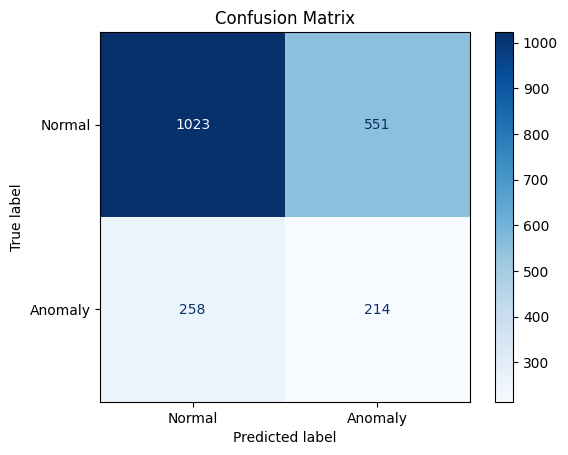

##############################
Test Evaluation
##############################


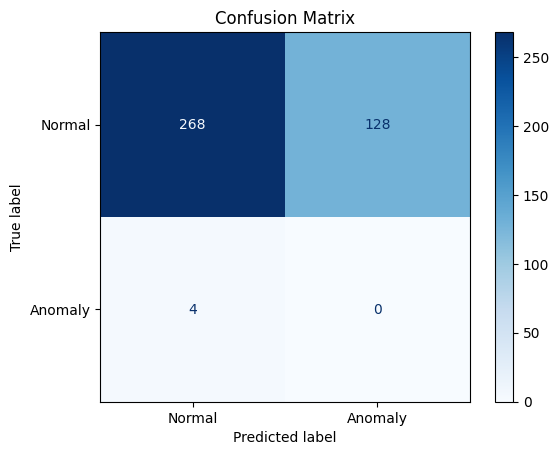

In [19]:
# wider param grid, smote

print("##############################")
print("Train Evaluation")
print("##############################")
grid_predictions = grid.predict(X_train_scaled_smote) 

conf_matrix = confusion_matrix(y_train_smote, grid_predictions, labels=[1, -1])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("##############################")
print("Test Evaluation")
print("##############################")

grid_predictions = grid.predict(X_test_scaled) 

conf_matrix = confusion_matrix(y_test_smote, grid_predictions, labels=[1, -1])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Risk scores

In [15]:
def get_risk_score(clf, X):
    def min_max_scaling(value, new_min, new_max):
        old_min = min(value)
        old_max = max(value)
        scaled_value = ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
        return scaled_value
    
    # distance from decision boundary where negative = non anomaly and positive = anomaly
    distances = clf.decision_function(X)
    risk_scores = min_max_scaling(distances, -1,1)
    
    return risk_scores


In [16]:
train_risk = get_risk_score(best_clf, X_train_scaled)
test_risk = get_risk_score(best_clf, X_test_scaled)

TODO: Rename to confidence score (modulus of risk) because bigger is better  
ADD AUC

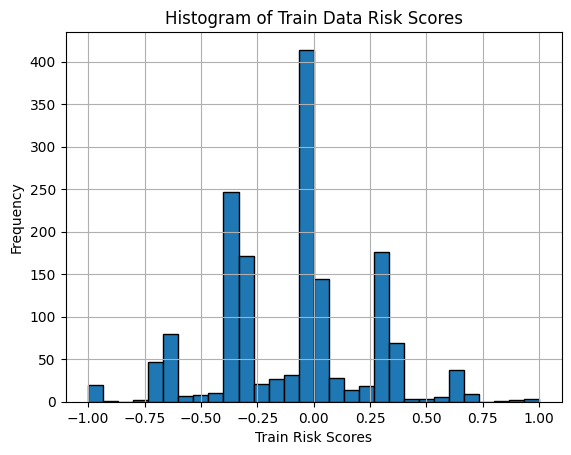

In [17]:
# Plot histogram
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Data Risk Scores')
plt.grid(True)
plt.show()

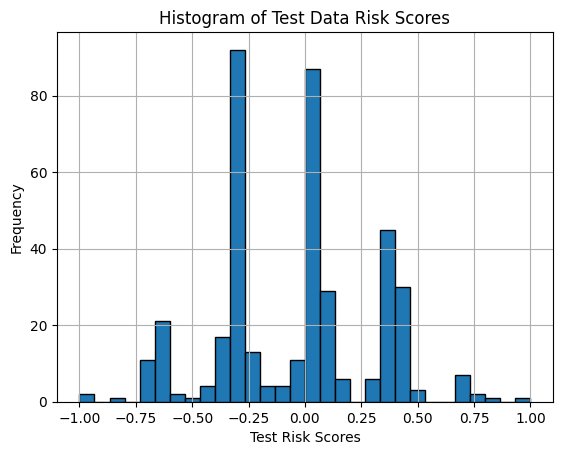

In [18]:
import matplotlib.pyplot as plt
# Plot histogram
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

In [19]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[-0.65403703 -0.32256257 -0.0517448  -0.02032487  0.35945298 -0.69463912
  0.28329003 -0.32144926  0.35415059 -0.01628515]

Example Test Risk Scores:
[ 0.75738716 -0.67409111 -0.28042474  0.07983322  0.03989024  0.03775803
  0.00332596 -0.34844985 -0.31595053  0.04900708]


## Export CSV of FP and FN names for entire dataset

In [20]:
train_pred = np.where(train_pred == -1, 1, 0)
test_pred = np.where(test_pred == -1, 1, 0)

In [21]:
# Filter out empty entries before concatenating
fp_train_names = X_train_w_name.iloc[np.where((y_train == 0) & (train_pred == 1))[0]]["user"]
fp_train_names = fp_train_names[fp_train_names.notnull()]  # Filter out NaNs if any
fp_test_names = X_test_w_name.iloc[np.where((y_test == 0) & (test_pred == 1))[0]]["user"]
fp_test_names = fp_test_names[fp_test_names.notnull()]  # Filter out NaNs if any
fn_train_names = X_train_w_name.iloc[np.where((y_train == 1) & (train_pred == 0))[0]]["user"]
fn_train_names = fn_train_names[fn_train_names.notnull()]  # Filter out NaNs if any
fn_test_names = X_test_w_name.iloc[np.where((y_test == 1) & (test_pred == 0))[0]]["user"]
fn_test_names = fn_test_names[fn_test_names.notnull()]  # Filter out NaNs if any

# Concatenate false positives and false negatives dataframes
fp_names = pd.concat([fp_train_names, fp_test_names], ignore_index=True)
fn_names = pd.concat([fn_train_names, fn_test_names], ignore_index=True)
# Create a dictionary with fp and fn dataframes
data = {'False Positives': fp_names, 'False Negatives': fn_names}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
df.to_csv('fp_fn_names.csv', index=False)

In [22]:
fn_names

0     ICB1354
1     NAH1366
2     HXP0976
3     OSS1463
4     SNK1280
5     CHP1711
6     VCF1602
7     JAL0811
8     CKP0630
9     GWG0497
10    MDS0680
11    DCC1119
12    TRC1838
13    RRS0056
14    BYO1846
15    HSN0675
16    ITA0159
17    ZIE0741
18    CIF1430
19    KSS1005
20    HMS1658
21    HIS1394
22    LVF1626
23    WDT1634
24    MGB1235
25    SIS0042
26    OKM1092
27    TNB1616
28    MCP0611
Name: user, dtype: string